In [1]:
import open3d as o3d
import numpy as np
import matplotlib.pyplot as plt
import yaml
import cv2
import time

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
def load_bev_sem_png(file_path):
    segmented_image = cv2.imread(file_path)
    #bev_sem = bev_sem[:,:,0]
    return segmented_image

In [2]:
def load_point_cloud(pcd_file):
    pcd = o3d.io.read_point_cloud(pcd_file)
    return np.asarray(pcd.points), pcd

def parse_yaml(yaml_file):
    with open(yaml_file, 'r') as file:
        data = yaml.safe_load(file)
    return data

In [3]:
# Example usage
pcd_file = "/home/nj644/dev/v2x-sim/OpenCOOD/data/train/2021_08_21_22_21_37/4722/000069.pcd"
yaml_file = "/home/nj644/dev/v2x-sim/OpenCOOD/data/train/2021_08_21_22_21_37/4722/000069.yaml"
# Second frame
pcd_file2 = "/home/nj644/dev/v2x-sim/OpenCOOD/data/train/2021_08_21_22_21_37/4722/000987.pcd"
yaml_file2 = "/home/nj644/dev/v2x-sim/OpenCOOD/data/train/2021_08_21_22_21_37/4722/000987.yaml"

points, pcd = load_point_cloud(pcd_file)
yaml_data = parse_yaml(yaml_file)

points2, pcd2 = load_point_cloud(pcd_file)
yaml_data2 = parse_yaml(yaml_file2)

In [4]:
def visualize_raw_point_cloud(file_path):
    # Load the point cloud from a file (e.g., .pcd, .ply)
    pcd = o3d.io.read_point_cloud(file_path)

    # Print some basic information about the point cloud
    print(pcd)
    print(np.asarray(pcd.points))

    # Visualize the raw point cloud
    o3d.visualization.draw_geometries([pcd])
visualize_raw_point_cloud(pcd_file)
visualize_raw_point_cloud(pcd_file2)


PointCloud with 39855 points.
[[-6.37238617e+01  7.80986156e-05  2.22529173e+00]
 [-6.36808891e+01 -2.55917221e-01  2.22380853e+00]
 [-6.38423119e+01 -5.13209164e-01  2.22949576e+00]
 ...
 [-1.61826622e+00  3.25285420e-02 -7.54759431e-01]
 [-1.64402437e+00  2.64385920e-02 -7.66715586e-01]
 [-1.59803522e+00  1.28426794e-02 -7.45199502e-01]]
PointCloud with 39670 points.
[[-6.97698898e+01 -1.12192631e+00  2.43672657e+00]
 [-7.05989075e+01 -1.41914797e+00  2.46586347e+00]
 [-7.10322952e+01 -1.71356273e+00  2.48122382e+00]
 ...
 [-1.66624880e+00  2.67963130e-02 -7.77087212e-01]
 [-1.61837077e+00  1.95213687e-02 -7.54713595e-01]
 [-1.68326926e+00  1.35375625e-02 -7.84943938e-01]]


In [5]:
def exclude_points_near_lidar(point_cloud, lidar_pose, radius=3.0):
    """
    Exclude points within a certain radius from the LiDAR pose.

    Args:
        point_cloud (np.ndarray): N x 3 array of LiDAR points (x, y, z).
        lidar_pose (tuple): LiDAR pose as (x, y, z).
        radius (float): Radius within which points will be excluded.

    Returns:
        np.ndarray: Filtered point cloud.
    """
    # Compute Euclidean distances from the LiDAR pose
    distances = np.linalg.norm(point_cloud[:, :3] - np.array(lidar_pose[:3]), axis=1)

    # Filter out points within the specified radius
    filtered_points = point_cloud[distances > radius]
    # Create Open3D PointCloud object
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(filtered_points)

    return pcd,filtered_points
points_filtered,filtered_points = exclude_points_near_lidar(points, [0,0,0])
points_filtered2,filtered_points2 = exclude_points_near_lidar(points2, [0,0,0])
o3d.visualization.draw_geometries([points_filtered])


In [72]:
def apply_ransac_to_point_cloud(points, distance_threshold=0.25, ransac_n=3, num_iterations=1500):
    # Convert points to open3d format
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(points)

    # Apply RANSAC to detect the ground plane
    plane_model, inliers =pcd.segment_plane(distance_threshold=distance_threshold,
                                             ransac_n=ransac_n,
                                             num_iterations=num_iterations)

    # Extract the plane coefficients
    # [a, b, c, d] = plane_model
    # print(f"Plane model: {a}x + {b}y + {c}z + {d} = 0")

    # Extract inlier points (those that belong to the plane)
    plane_points = points[inliers]

    # Extract outlier points (those that do not belong to the plane)
    non_plane_points = points[np.setdiff1d(np.arange(len(points)), inliers)]

    return plane_points, non_plane_points, plane_model

In [49]:
def visualize_ransac_classification(ground_points, non_ground_points):
    # Create Open3D point cloud objects for ground and non-ground points
    ground_pcd = o3d.geometry.PointCloud()
    non_ground_pcd = o3d.geometry.PointCloud()

    # Set the points for the point clouds
    ground_pcd.points = o3d.utility.Vector3dVector(ground_points)
    non_ground_pcd.points = o3d.utility.Vector3dVector(non_ground_points)

    # Assign colors: green for ground points, red for non-ground points
    ground_pcd.paint_uniform_color([0, 1, 0])  # Green
    non_ground_pcd.paint_uniform_color([1, 0, 0])  # Red

    # Visualize the point clouds together
    o3d.visualization.draw_geometries([ground_pcd, non_ground_pcd])

In [50]:
lidar_road, lidar_nonroad, plane_model = apply_ransac_to_point_cloud(filtered_points)
lidar_road2, lidar_nonroad2, plane_model2 = apply_ransac_to_point_cloud(filtered_points2)
visualize_ransac_classification(lidar_road, lidar_nonroad)
visualize_ransac_classification(lidar_road2, lidar_nonroad2)

Plane model: 0.0037005006143910717x + -0.0032315618918069343y + 0.9999879315786478z + 1.9012421541217084 = 0
Plane model: 0.00328356657121063x + -0.001026609617028471y + 0.9999940821141226z + 1.9050484180787597 = 0


In [51]:
ALPHA = 1
BHETA = 1*np.pi/180
RESOLUTION = 0.1
MAX_RANGE = 50
MAP_WIDTH = 100
SPHERICAL2CARTESIAN_BIAS = 6

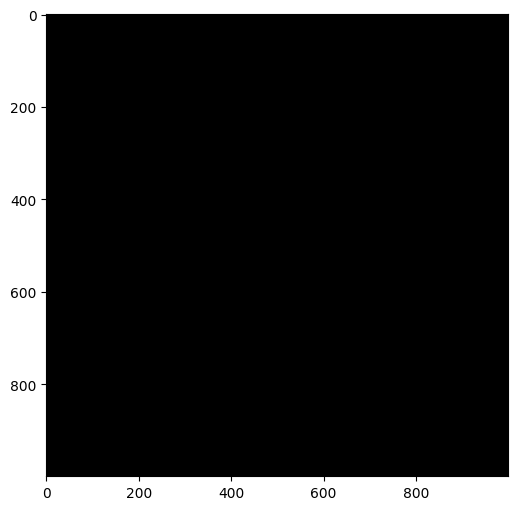

In [52]:
## Some derived parameters
# OOR_MASK = A mask to filter out measurements that are out of MAX_RANGE
MAP_SIZE_X = int(MAP_WIDTH/RESOLUTION)
MAP_SIZE_Y = int(MAP_WIDTH/RESOLUTION)
xarr = np.arange(-MAP_WIDTH/2,MAP_WIDTH/2,RESOLUTION)
yarr = np.arange(-MAP_WIDTH/2,MAP_WIDTH/2,RESOLUTION)
MAP_XX, MAP_YY = np.meshgrid(xarr, -yarr)
rgrid = np.sqrt(np.add(np.square(MAP_XX),np.square(MAP_YY)))
OOR_MASK = rgrid >= MAX_RANGE

### Initialize OGM
ogm_time_0 = np.ones((MAP_SIZE_Y,MAP_SIZE_X)) * 0.5

### Only use the x-z axis of the point (ignore the height axis)
lidar_ogm = lidar_nonroad[:,[0,1]]
lidar_ogm2 = lidar_nonroad2[:,[0,1]]

### Visualize
# Yes, it's still empty
plt.figure(figsize=(6, 6))
plt.imshow(ogm_time_0,cmap='gray',vmax=1)
plt.show()

In [53]:
def generate_measurement_ogm(lidar_in,ogm_shape):
  ### Calculate the position of LiDAR points in spherical coordinate
  rphi_meas = np.zeros((lidar_in.shape[0],2))
  rphi_meas[:,1] = np.sqrt(np.add(np.square(lidar_in[:,0]),np.square(lidar_in[:,1])))/ALPHA
  rphi_meas[:,0] = (np.arctan2(lidar_in[:,1],lidar_in[:,0])+np.pi)/BHETA
  rphi_meas = np.unique(rphi_meas.astype(int),axis=0)
  rphi_meas = rphi_meas[rphi_meas[:,1]<int(MAX_RANGE/ALPHA),:]
  rphi_meas = rphi_meas[rphi_meas[:,0]<int(2*np.pi/BHETA),:]

  ### Initiate and fill the spherical scan grid
  sg_ang_bin = int(2*np.pi/BHETA)
  sg_rng_bin = int(MAX_RANGE/ALPHA)
  # Initiation (Condition 3)
  scan_grid = np.ones((sg_ang_bin,sg_rng_bin))*0.5
  # Condition 1
  scan_grid[tuple(rphi_meas.T)] = 0.7
  # Condition 2
  for ang in range(sg_ang_bin):
    ang_arr = rphi_meas[rphi_meas[:,0]==ang,1]
    if len(ang_arr) == 0:
      scan_grid[ang,:] = 0.3
    else:
      min_r = np.min(ang_arr)
      scan_grid[ang,:min_r] = 0.3
  
  ### Convert the spherical scan grid to the cartesian one
  ogm_sz = (ogm_shape[1],ogm_shape[0])
  ogm_cen = (int(ogm_shape[1]/2),int(ogm_shape[0]/2))
  radius = (MAX_RANGE/RESOLUTION) + SPHERICAL2CARTESIAN_BIAS
  ogm_step = cv2.warpPolar(scan_grid,ogm_sz,ogm_cen,radius,cv2.WARP_INVERSE_MAP)
  ogm_step[OOR_MASK] = 0.5
  ogm_step = cv2.rotate(ogm_step, cv2.ROTATE_90_CLOCKWISE)
  return ogm_step

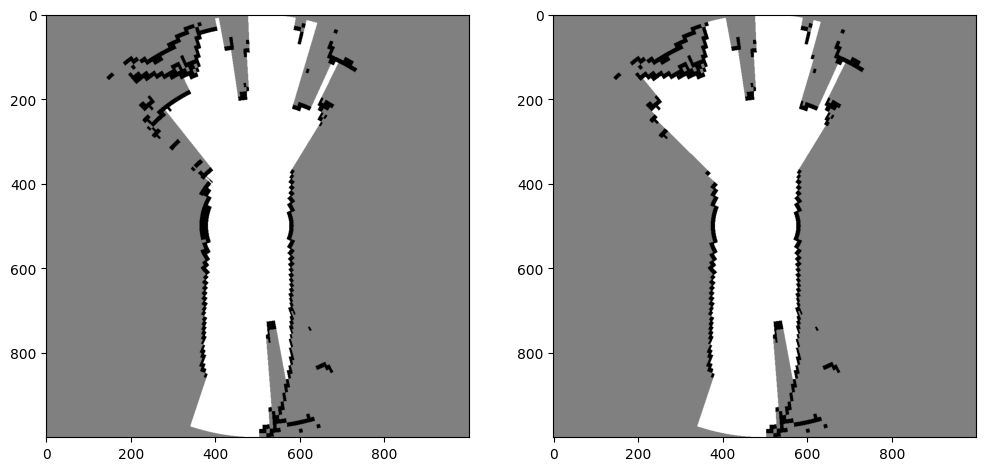

In [54]:
ogm_step = generate_measurement_ogm(lidar_ogm,ogm_time_0.shape)
ogm_step2 = generate_measurement_ogm(lidar_ogm2,ogm_time_0.shape)
### Visualize
fig,axs = plt.subplots(1,2,figsize=(12,6))
axs[0].imshow(((1-ogm_step)*255).astype(np.uint8),cmap='gray')
axs[1].imshow(((1-ogm_step2)*255).astype(np.uint8),cmap='gray')
plt.show()

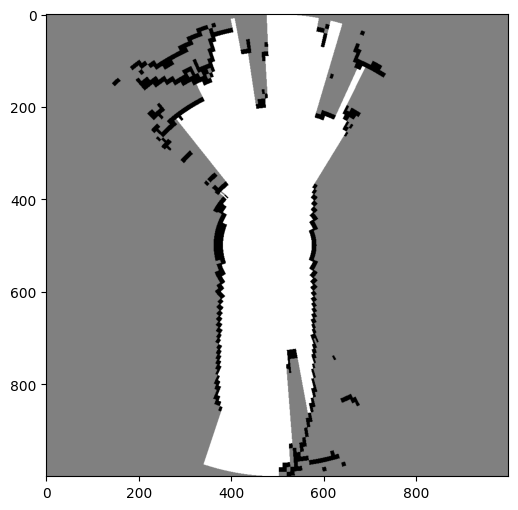

In [55]:
### Calculate the logit function
def logit(m):
  return np.log(np.divide(m, np.subtract(1, m)))

### Calculate the inverse logit function
def inverse_logit(m):
  return np.divide(np.exp(m),np.add(1,np.exp(m)))

### Update the prior OGM with the scan grid (new_ogm)
def update_ogm(prior_ogm,new_ogm):
  logit_map = logit(new_ogm) + logit(prior_ogm)
  out_ogm = inverse_logit(logit_map)
  out_ogm[out_ogm>=0.98] = 0.98
  out_ogm[out_ogm<=0.02] = 0.02
  return out_ogm

ogm_time_1 = update_ogm(ogm_step,ogm_time_0)

### Visualize
fig,axs = plt.subplots(1,1,figsize=(6,6))
axs.imshow(((1-ogm_time_1)*255).astype(np.uint8),cmap='gray')
plt.show()

In [39]:
# ### Load the vehicle's pose based on velocity data
# def load_vehicle_pose_vel(yaml_data,old_pose,delta_t):
#   yaw = old_pose[2]
#   true_ego_pos = yaml_data['true_ego_pos']
#   ego_speed = yaml_data['ego_speed']/3.6
#   delta_x = ego_speed * delta_t
#   delta_y = ego_speed * delta_t
#   new_x = old_pose[0] + delta_x
#   new_y = old_pose[1] + delta_y
#   new_yaw = true_ego_pos[4]
#   return (new_x, new_y, new_yaw)

# pose = load_vehicle_pose_vel(yaml_data,(0,0,0),0)
# pose2 = load_vehicle_pose_vel(yaml_data2,pose,1.2)


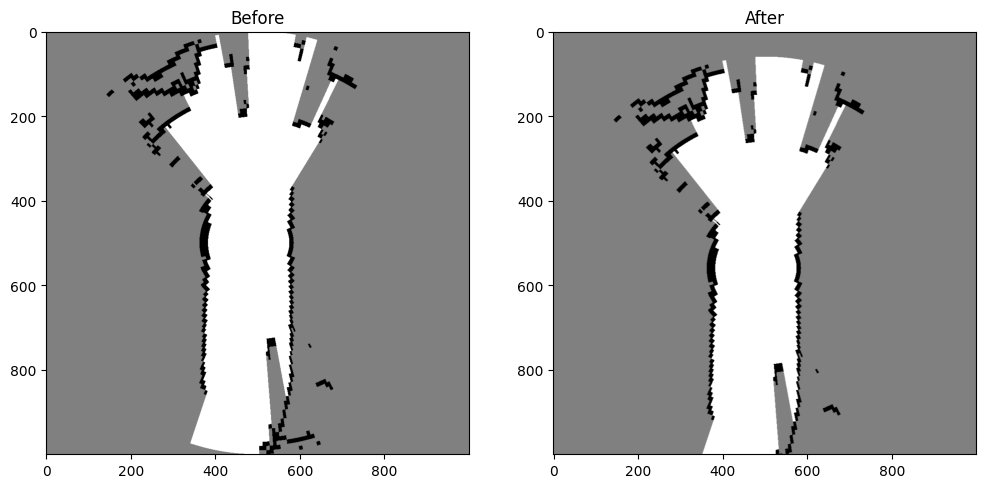

In [56]:
# Shift the map according the vehicle's poses
def shift_ogm_based_on_pose(ogm, yaml_data, yaml_data2):
    ogm_copy = ogm.copy()
    init_pose = [yaml_data['predicted_ego_pos'][0], yaml_data['predicted_ego_pos'][1], yaml_data['predicted_ego_pos'][5]]  # (x, y, yaw)
    fin_pose = [yaml_data2['predicted_ego_pos'][0], yaml_data2['predicted_ego_pos'][1], yaml_data2['predicted_ego_pos'][5]]
    # Extract rotation and translation components from poses
    theta = init_pose[2]  # Initial yaw in radians
    rot_m = np.array([[np.cos(theta), np.sin(theta)], [-np.sin(theta), np.cos(theta)]])
    translation = np.array([[init_pose[0]], [init_pose[1]]])  # Initial position (x, y)
    delta_pose = np.array(fin_pose[:2]).reshape((-1, 1)) - translation  # Position difference
    delta_pose_rot = np.dot(rot_m, -delta_pose)
    delta_theta = fin_pose[2] - init_pose[2]  # Yaw difference
    
    # Calculate translation in grid coordinates
    delta = np.array([delta_pose_rot[1, 0] / RESOLUTION, delta_pose_rot[0, 0] / RESOLUTION, 0])

    # Apply translation
    M_translate = np.array([[1, 0, delta[0]], [0, 1, -delta[1]]])
    shifted_ogm = cv2.warpAffine(ogm_copy, M_translate, (ogm_copy.shape[1], ogm_copy.shape[0]), borderValue=0.5)

    # Apply rotation
    center = (ogm_copy.shape[1] / 2 + 0.5, ogm_copy.shape[0] / 2 + 0.5)
    M_rotate = cv2.getRotationMatrix2D(center, np.degrees(delta_theta), 1)
    shifted_ogm = cv2.warpAffine(shifted_ogm, M_rotate, (ogm_copy.shape[1], ogm_copy.shape[0]), borderValue=0.5)
    
    return shifted_ogm

shift_ogm_time_1 = shift_ogm_based_on_pose(ogm_time_1,yaml_data,yaml_data2)

### Visualize
fig,axs = plt.subplots(1,2,figsize=(12,6))
axs[0].imshow(((1-ogm_time_1)*255).astype(np.uint8),cmap='gray')
axs[0].set_title('Before')
axs[1].imshow(((1-shift_ogm_time_1)*255).astype(np.uint8),cmap='gray')
axs[1].set_title('After')
plt.show()

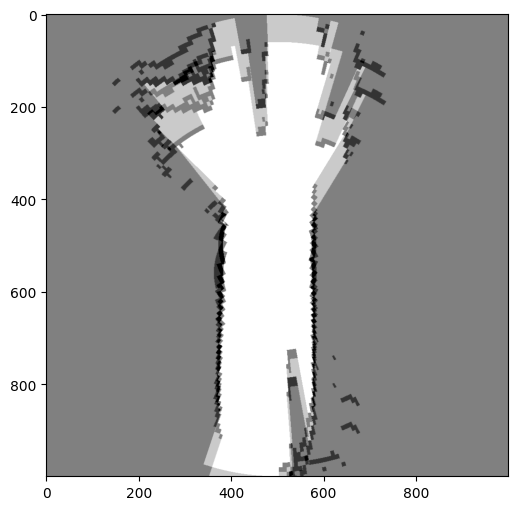

In [57]:
ogm_time_2 = update_ogm(ogm_step2,shift_ogm_time_1)

### Visualize
fig,axs = plt.subplots(1,1,figsize=(6,6))
axs.imshow(((1-ogm_time_2)*255).astype(np.uint8),cmap='gray')
plt.show()

In [58]:
ALPHA = 1
BHETA = 1*np.pi/180
RESOLUTION = 0.1
MAX_RANGE = 50
MAP_WIDTH = 100
SPHERICAL2CARTESIAN_BIAS = 6
FREE_CONF = 0.7
OCC_CONF = 0.7
DYNAMIC_THRESHOLD = 0.3

In [59]:
MAP_SIZE_X = int(MAP_WIDTH/RESOLUTION)
MAP_SIZE_Y = int(MAP_WIDTH/RESOLUTION)
xarr = np.arange(-MAP_WIDTH/2,MAP_WIDTH/2,RESOLUTION)
yarr = np.arange(-MAP_WIDTH/2,MAP_WIDTH/2,RESOLUTION)
MAP_XX, MAP_YY = np.meshgrid(xarr, -yarr)
rgrid = np.sqrt(np.add(np.square(MAP_XX),np.square(MAP_YY)))
OOR_MASK = rgrid >= MAX_RANGE

'''
DGM Channel:
Channel 0 = {F,O}
Channel 1 = O
Channel 2 = F
'''
dgm_time_0 = np.zeros((MAP_SIZE_Y,MAP_SIZE_X,3))
dgm_time_0[:,:,0] = 1 

lidar_dgm = lidar_nonroad[:,[0,1]]
lidar_dgm2 = lidar_nonroad2[:,[0,1]]

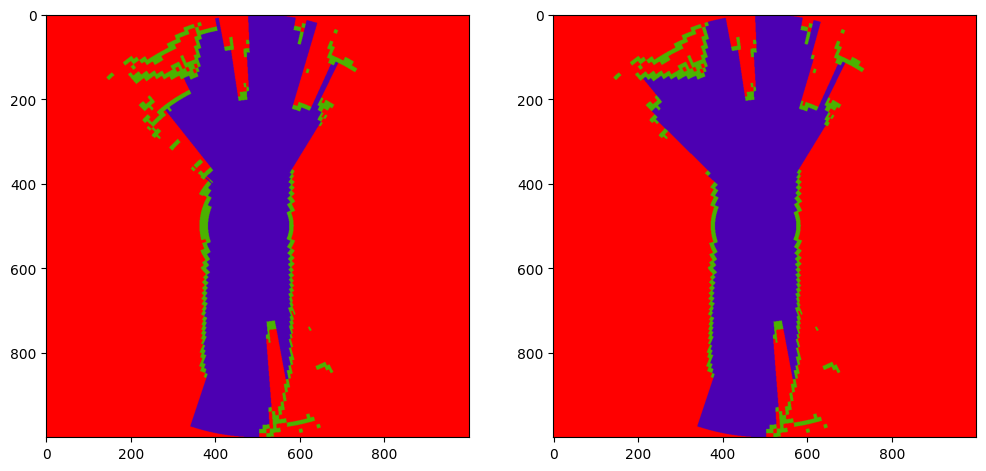

In [60]:
def generate_measurement_dgm(lidar_in,dgm_shape):
  ### Calculate the position of LiDAR points in spherical coordinate
  rphi_meas = np.zeros((lidar_in.shape[0],2))
  rphi_meas[:,1] = np.sqrt(np.add(np.square(lidar_in[:,0]),np.square(lidar_in[:,1])))/ALPHA
  rphi_meas[:,0] = (np.arctan2(lidar_in[:,1],lidar_in[:,0])+np.pi)/BHETA
  rphi_meas = np.unique(rphi_meas.astype(int),axis=0)
  rphi_meas = rphi_meas[rphi_meas[:,1]<int(MAX_RANGE/ALPHA),:]
  rphi_meas = rphi_meas[rphi_meas[:,0]<int(2*np.pi/BHETA),:]

  ### Initiate and fill the spherical scan grid
  sg_ang_bin = int(2*np.pi/BHETA)
  sg_rng_bin = int(MAX_RANGE/ALPHA)
  scan_grid = np.zeros((sg_ang_bin,sg_rng_bin,3))
  scan_grid[:,:,0] = 1 
  scan_grid[tuple(rphi_meas.T)] = (1-OCC_CONF,OCC_CONF,0)
  for ang in range(sg_ang_bin):
    ang_arr = rphi_meas[rphi_meas[:,0]==ang,1]
    if len(ang_arr) == 0:
      scan_grid[ang,:] = (1-FREE_CONF,0,FREE_CONF)
    else:
      min_r = np.min(ang_arr)
      scan_grid[ang,:min_r] = (1-FREE_CONF,0,FREE_CONF)
  
  ### Convert the spherical scan grid to the cartesian one
  dgm_sz = (dgm_shape[1],dgm_shape[0])
  dgm_cen = (int(dgm_shape[1]/2),int(dgm_shape[0]/2))
  radius = (MAX_RANGE/RESOLUTION) + SPHERICAL2CARTESIAN_BIAS
  dgm_step = cv2.warpPolar(scan_grid,dgm_sz,dgm_cen,radius,cv2.WARP_INVERSE_MAP)
  dgm_step[OOR_MASK] = (1,0,0)
  dgm_step = cv2.rotate(dgm_step, cv2.ROTATE_90_CLOCKWISE)
  return dgm_step

dgm_step = generate_measurement_dgm(lidar_dgm,dgm_time_0.shape)
dgm_step2 = generate_measurement_dgm(lidar_dgm2,dgm_time_0.shape)

### Visualize
fig,axs = plt.subplots(1,2,figsize=(12,6))
axs[0].imshow((dgm_step*255).astype(np.uint8))
axs[1].imshow((dgm_step2*255).astype(np.uint8))
plt.show()

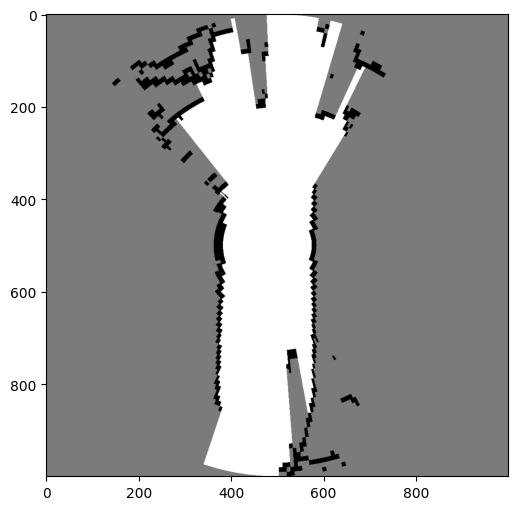

In [61]:
### Update the DGM with DST rule of combination
def update_dgm(prior_dgm,new_dgm):
  ### Calculate conflicting mass
  conflict_mass = np.multiply(prior_dgm[:,:,2],new_dgm[:,:,1])
  conflict_mass = np.add(conflict_mass,np.multiply(prior_dgm[:,:,1],new_dgm[:,:,2]))

  ### Calculate free mass
  free_mass = np.multiply(prior_dgm[:,:,0],new_dgm[:,:,2])
  free_mass = np.add(free_mass,np.multiply(prior_dgm[:,:,2],new_dgm[:,:,0]))
  free_mass = np.add(free_mass,np.multiply(prior_dgm[:,:,2],new_dgm[:,:,2]))
  free_mass = np.divide(free_mass,1-conflict_mass)

  ### Calculate occupied mass
  occ_mass = np.multiply(prior_dgm[:,:,0],new_dgm[:,:,1])
  occ_mass = np.add(occ_mass,np.multiply(prior_dgm[:,:,1],new_dgm[:,:,0]))
  occ_mass = np.add(occ_mass,np.multiply(prior_dgm[:,:,1],new_dgm[:,:,1]))
  occ_mass = np.divide(occ_mass,1-conflict_mass)

  ### Calculate unknown mass
  unknown_mass = np.multiply(prior_dgm[:,:,0],new_dgm[:,:,0])
  unknown_mass = np.divide(unknown_mass,1-conflict_mass)

  updated_dgm = np.stack((unknown_mass,occ_mass,free_mass),axis=2)
  return updated_dgm,conflict_mass

### Convert the DGM to a displayable figure
def predict_dgm(dgm,dynamic_mass):
  max_mass = np.argmax(dgm,axis=2)
  pred_map = np.zeros(dgm.shape)
  # The unknown cells: gray
  pred_map[max_mass==0] = (123,123,123)
  # The occupied cells: black
  pred_map[max_mass==1] = (0,0,0)
  # The free cells: white
  pred_map[max_mass==2] = (255,255,255)
  # The dynamic cells: blue
  pred_map[dynamic_mass>=DYNAMIC_THRESHOLD] = (0,0,255)
  return pred_map.astype(np.uint8)

dgm_time_1,dynamic_mass_1 = update_dgm(dgm_time_0,dgm_step)
dgm_pred_1 = predict_dgm(dgm_time_1,dynamic_mass_1)

fig,axs = plt.subplots(1,1,figsize=(6,6))
axs.imshow(dgm_pred_1)
plt.show()

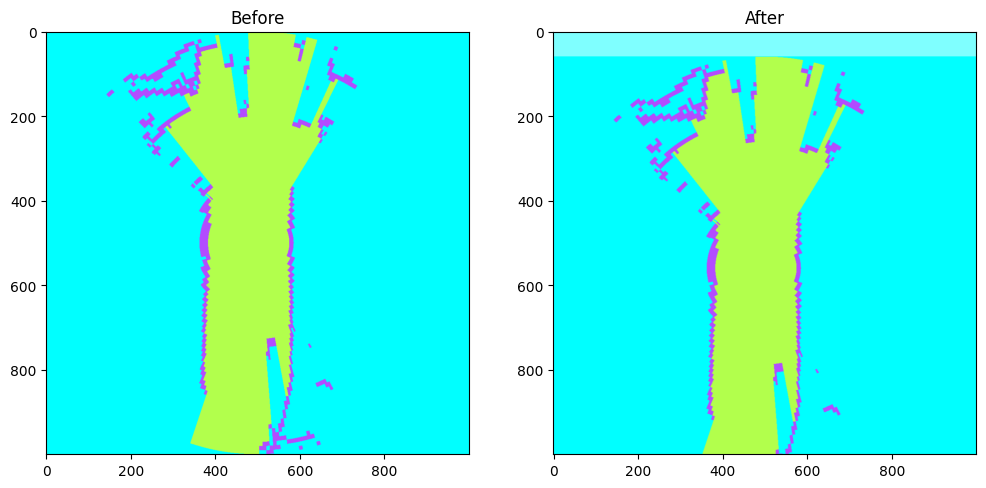

In [62]:
shift_dgm_time_1 = shift_ogm_based_on_pose(dgm_time_1,yaml_data,yaml_data2)

### Visualize
fig,axs = plt.subplots(1,2,figsize=(12,6))
axs[0].imshow(((1-dgm_time_1)*255).astype(np.uint8),cmap='gray')
axs[0].set_title('Before')
axs[1].imshow(((1-shift_dgm_time_1)*255).astype(np.uint8),cmap='gray')
axs[1].set_title('After')
plt.show()

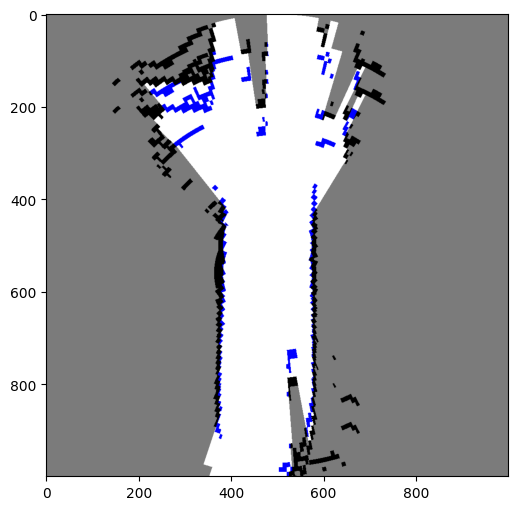

In [63]:
dgm_time_2,dynamic_mass_2 = update_dgm(shift_dgm_time_1,dgm_step2)
dgm_pred_2 = predict_dgm(dgm_time_2,dynamic_mass_2)

fig,axs = plt.subplots(1,1,figsize=(6,6))
axs.imshow(dgm_pred_2)
plt.show()

In [74]:
import cv2
import os
# Define the path to the directory containing PCD and YAML files
# Load PCD and YAML files
data_dir = "/home/nj644/dev/v2x-sim/OpenCOOD/data/train/2021_08_18_19_11_02/3242/"
pcd_files = sorted([os.path.join(data_dir, f) for f in os.listdir(data_dir) if f.endswith(".pcd")])
yaml_files = sorted([os.path.join(data_dir, f) for f in os.listdir(data_dir) if f.endswith(".yaml")])

# Paths to save OGM and DGM images
ogm_output_dir = "ogm_images"
dgm_output_dir = "dgm_images"
os.makedirs(ogm_output_dir, exist_ok=True)
os.makedirs(dgm_output_dir, exist_ok=True)

# Initialize OGM and DGM
ogm = np.ones((MAP_SIZE_Y, MAP_SIZE_X)) * 0.5
dgm = np.zeros((MAP_SIZE_Y, MAP_SIZE_X, 3))
dgm[:, :, 0] = 1  # Initialize as fully unknown

# Initial pose

In [75]:
for i in range(1, len(pcd_files)-50):
    # Load current data
    points, _ = load_point_cloud(pcd_files[i])
    curr_yaml = parse_yaml(yaml_files[i])
    
    # Exclude points near LiDAR
    _, filtered_points = exclude_points_near_lidar(points, [0, 0, 0])
    
    # Apply RANSAC to classify points
    lidar_road, lidar_nonroad, _ = apply_ransac_to_point_cloud(filtered_points)
    
    # Generate OGM and DGM measurements
    ogm_step = generate_measurement_ogm(lidar_nonroad, ogm.shape)
    dgm_step = generate_measurement_dgm(lidar_nonroad[:, :2], dgm.shape)
    
    # Shift OGM and DGM based on poses
    ogm = shift_ogm_based_on_pose(ogm, prev_yaml, curr_yaml)
    dgm = shift_ogm_based_on_pose(dgm, prev_yaml, curr_yaml)
    
    # Update OGM and DGM
    ogm = update_ogm(ogm, ogm_step)
    dgm, dynamic_mass = update_dgm(dgm, dgm_step)
    
    # Save previous YAML for the next iteration
    prev_yaml = curr_yaml
    
    # Save OGM image
    ogm_frame = ((1 - ogm) * 255).astype(np.uint8)
    ogm_filename = os.path.join(ogm_output_dir, f"ogm_frame_{i:06d}.png")
    cv2.imwrite(ogm_filename, ogm_frame)
    
    # Save DGM image
    dgm_pred = predict_dgm(dgm, dynamic_mass)
    dgm_frame = cv2.cvtColor(dgm_pred, cv2.COLOR_RGB2BGR)
    dgm_filename = os.path.join(dgm_output_dir, f"dgm_frame_{i:06d}.png")
    cv2.imwrite(dgm_filename, dgm_frame)

print(f"OGM images saved in {ogm_output_dir}")
print(f"DGM images saved in {dgm_output_dir}")

OGM images saved in ogm_images
DGM images saved in dgm_images
